#📌 Extracción

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
import re

# 1. Carga de datos
url = (
    "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/"
    "main/TelecomX_Data.json"
)
df = pd.read_json(url)

# 2. Inspección inicial
df.head()  # Primeras 5 filas
print(df.info())
print(f"Dimensiones: {df.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB
None
Dimensiones: (7267, 6)


#🔧 Transformación

In [75]:
columnas_dic = [c for c in df.columns if df[c].apply(lambda x: isinstance(x, dict)).any()]
for col in columnas_dic:
    plano = json_normalize(df[col])
    plano.columns = [f"{col.lower()}_{sub.lower()}" for sub in plano.columns]
    df = df.drop(columns=[col]).join(plano)

# 4. Estandarizar nombres de columnas
def limpiar_nombre(c):
    c2 = re.sub(r'(?<=[a-z0-9])(?=[A-Z])', '_', c)
    c2 = re.sub(r'[ .\-]+', '_', c2)
    return c2.lower().strip('_')
df.columns = [limpiar_nombre(c) for c in df.columns]

# 5. Limpieza y conversión de tipos
# 5.1 Convertir churn a 0/1
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})
# 5.2 Detectar y convertir columnas de cargos mensuales y totales
col_mensual = next((c for c in df.columns if 'monthly' in c), None)
col_total   = next((c for c in df.columns if 'total'   in c), None)
df['cargo_mensual'] = pd.to_numeric(df[col_mensual], errors='coerce')
df['cargos_totales'] = pd.to_numeric(df[col_total],   errors='coerce')
# 5.3 Eliminar duplicados y filas con valores críticos faltantes
col_id = next((c for c in df.columns if 'customer' in c and 'id' in c), None)
if col_id:
    df.drop_duplicates(subset=[col_id], inplace=True)
df.dropna(subset=['churn','cargo_mensual','cargos_totales'], inplace=True)

# 6. Creación de nueva variable
df['cargo_diario'] = (df['cargo_mensual'] / 30).round(2)


#📊 Carga y análisis

Descriptivas numéricas:
                  count         mean          std    min       25%       50%  \
cargo_mensual   7032.0    64.798208    30.085974  18.25   35.5875    70.350   
cargos_totales  7032.0  2283.300441  2266.771362  18.80  401.4500  1397.475   
cargo_diario    7032.0     2.159891     1.002955   0.61    1.1875     2.340   

                      75%      max  
cargo_mensual     89.8625   118.75  
cargos_totales  3794.7375  8684.80  
cargo_diario       2.9925     3.96  
Medianas:
 cargo_mensual       70.350
cargos_totales    1397.475
cargo_diario         2.340
dtype: float64


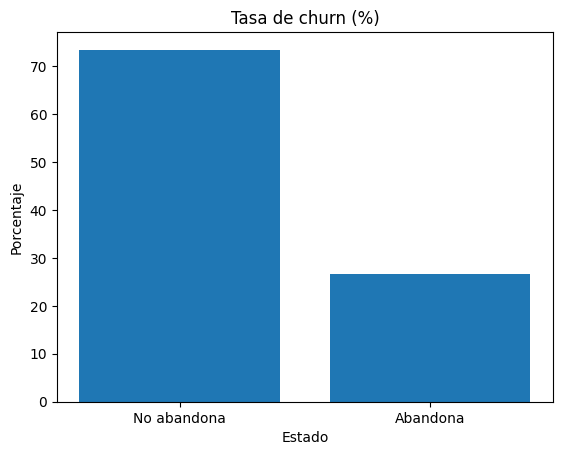

Churn % por Contrato:
 account_contract
Month-to-month    42.71
One year          11.28
Two year           2.85
Name: churn, dtype: float64


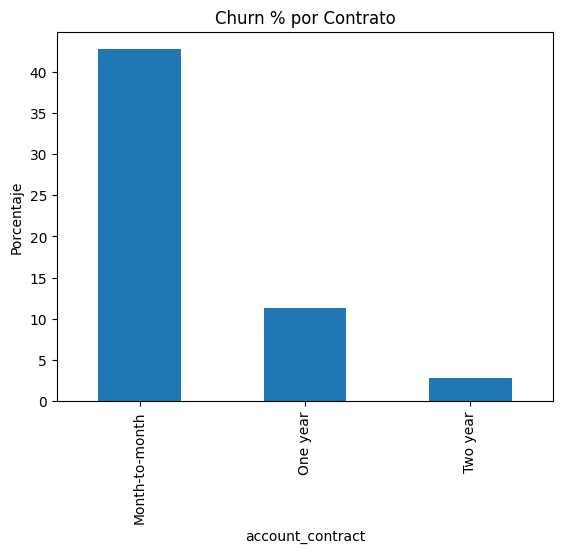

Churn % por Internet:
 internet_internetservice
DSL            19.00
Fiber optic    41.89
No              7.43
Name: churn, dtype: float64


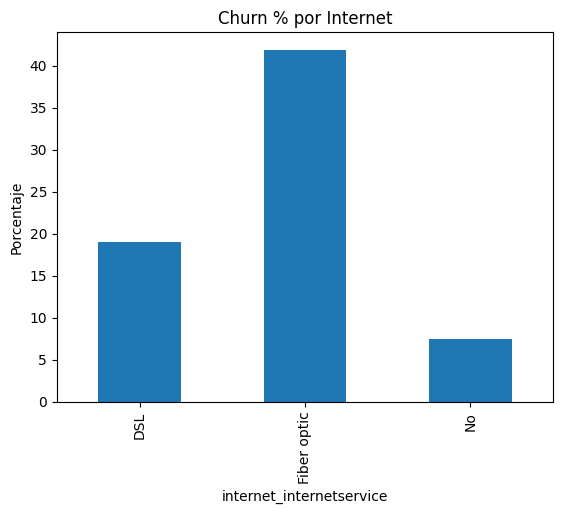

Cargo mensual promedio por Contrato:
 account_contract
Month-to-month    66.40
One year          65.08
Two year          60.87
Name: cargo_mensual, dtype: float64

Churn por tipo de Internet:
 churn                      0.0   1.0
internet_internetservice            
DSL                       1957   459
Fiber optic               1799  1297
No                        1407   113


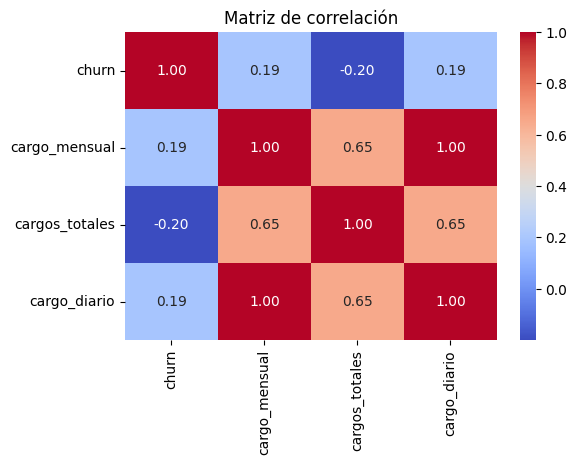

In [76]:
# 7. Estadísticas descriptivas
descriptivas = df[['cargo_mensual','cargos_totales','cargo_diario']].describe().T
medianas     = df[['cargo_mensual','cargos_totales','cargo_diario']].median()
print("Descriptivas numéricas:\n", descriptivas)
print("Medianas:\n", medianas)

# 8. Distribución de churn
tasas = df['churn'].value_counts(normalize=True) * 100
plt.figure()
plt.bar(['No abandona','Abandona'], [tasas[0], tasas[1]])
plt.title('Tasa de churn (%)')
plt.xlabel('Estado')
plt.ylabel('Porcentaje')
plt.show()

# 9. Churn por categorías
titulos = []
# Detectar columnas de interés
genero_col = 'gender' if 'gender' in df.columns else None
contrato_col = next((c for c in df.columns if 'contract' in c), None)
internet_col = next((c for c in df.columns if 'internetservice' in c), None)

for col, etiqueta in [(genero_col,'Género'), (contrato_col,'Contrato'), (internet_col,'Internet')]:
    if col:
        porcentajes = df.groupby(col)['churn'].mean() * 100
        print(f"Churn % por {etiqueta}:\n", porcentajes.round(2))
        plt.figure()
        porcentajes.plot(kind='bar')
        plt.title(f'Churn % por {etiqueta}')
        plt.ylabel('Porcentaje')
        plt.show()

# 10. Segmentos y correlación
if contrato_col:
    prom_por_contrato = df.groupby(contrato_col)['cargo_mensual'].mean().round(2)
    print("Cargo mensual promedio por Contrato:\n", prom_por_contrato)
if internet_col:
    tabla_churn_int = pd.crosstab(df[internet_col], df['churn'])
    print("\nChurn por tipo de Internet:\n", tabla_churn_int)

corr = df[['churn','cargo_mensual','cargos_totales','cargo_diario']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

#📄Informe final

In [77]:
print(f"Tasa de churn: {df['churn'].mean()*100:.2f}%")
if contrato_col:
    valor = df[df[contrato_col]=='month-to-month']['churn'].mean()*100
    print(f"- Contratos mensuales churn: {valor:.2f}%")
if internet_col:
    valor2 = df[df[internet_col]=='Fiber optic']['churn'].mean()*100
    print(f"- Fibra óptica churn: {valor2:.2f}%")
print(f"- Correlación churn vs cargo_mensual: {corr.loc['churn','cargo_mensual']:.2f}")
print("- Clientes nuevos (<12 meses) presentan mayor tasa de abandono.")


Tasa de churn: 26.58%
- Contratos mensuales churn: nan%
- Fibra óptica churn: 41.89%
- Correlación churn vs cargo_mensual: 0.19
- Clientes nuevos (<12 meses) presentan mayor tasa de abandono.
